In [6]:
import sys
sys.path.append("..")
from src import model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import seaborn as sns

log_theta_file = "luad_mixed_20_8_0035"
cancer_type = "luad"
event_file = "G12_PAADPANET_PM_z10_Events_30and5_Full"

log_theta = pd.read_csv(
    f"../results/{cancer_type}/{log_theta_file}.csv", index_col=0)
tau1, tau2 = np.exp(log_theta.pop("Sampling").iloc[:2])
events = log_theta.columns
log_theta = log_theta.to_numpy()
n = log_theta.shape[0] - 1

simulated = np.load(f"../simulations/{cancer_type}/{log_theta_file}.npy")


This is a densityplot of the PT and Met Development

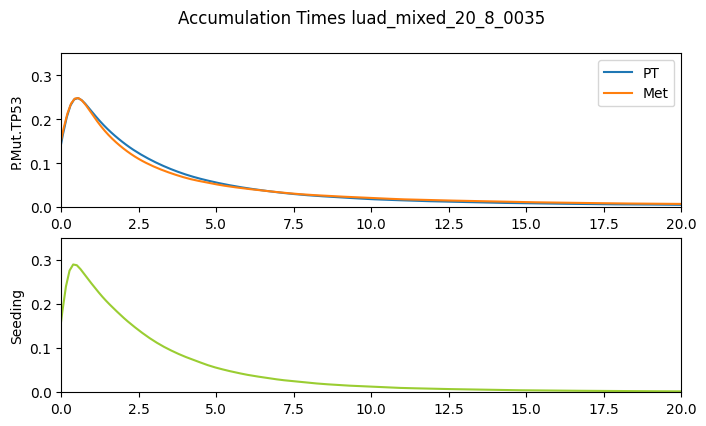

In [4]:
k = 1
k = min(k, n)
f, a = plt.subplots(k + 1, figsize=(8, (k+1) * 1.7 + 1))
x_lim = 20
for i in range(k):
    a[i].set_ylim((0, 0.35))
    a[i].set_xlim((0, x_lim))
    a[i].set_ylabel(events[i])
    sns.kdeplot(
        np.array(simulated[:, 2 * i][simulated[:, 2 * i] < x_lim * 1.1]), ax=a[i], label="PT")
    sns.kdeplot(np.array(
        simulated[:, 2 * i + 1][simulated[:, 2 * i + 1] < x_lim * 1.1]), ax=a[i], label="Met")
    a[i].legend()
a[-1].set_ylim((0, 0.35))
a[-1].set_xlim((0, x_lim))
a[-1].set_ylabel(events[-1])
sns.kdeplot(np.array(simulated[:, -1][simulated[:, -1] < x_lim * 1.1]),
            ax=a[-1], color="yellowgreen")
f.suptitle(f"Accumulation Times {log_theta_file}")
f.savefig(
    dpi=200, fname=f"../viz/{cancer_type}/{log_theta_file}_accumulation_times.png")


In [2]:
means = simulated.mean(axis=0)


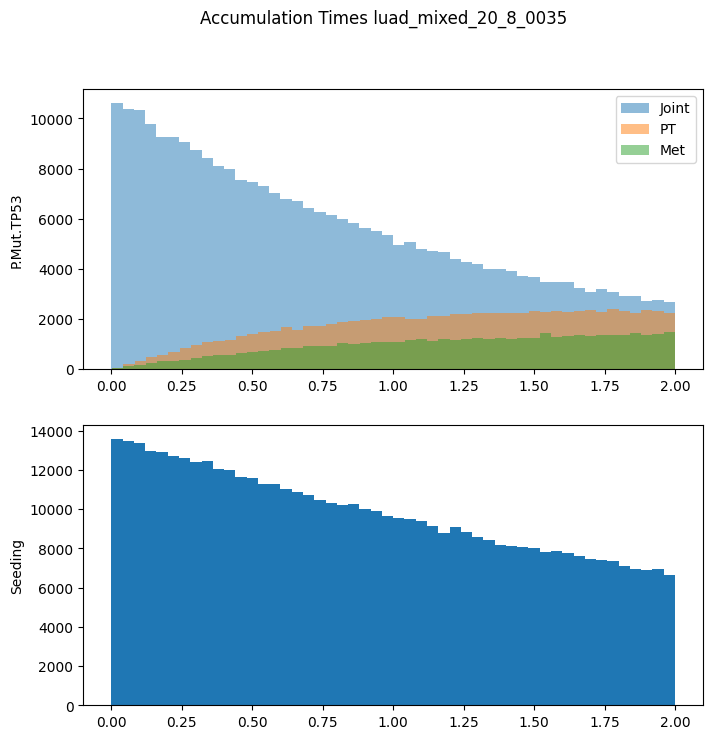

In [5]:
k = 1        # number of considered events
k = min(k, n)
f, a = plt.subplots(k + 1, figsize=(8, (k+1) * 3.5 + 1))
x_lim = 2
y_lim = 0.1
n_bins = 100
for i in range(k):
    # Take P.event column, M.event column and Seeding column from data
    subdata = simulated[:, [2*i, 2*i + 1, -1]]
    # separate into joint development, pt and met
    joint = subdata[:, 0][subdata[:, 0] < subdata[:, -1]]
    pt = subdata[:, 0][subdata[:, 0] > subdata[:, -1]]
    met = subdata[:, 1][subdata[:, 1] > subdata[:, -1]]

    for dat, label in zip([joint, pt, met], ["Joint", "PT", "Met"]):
        # make histogram from data
        # y, x = np.histogram(dat[dat < x_lim], bins=n_bins)
        # bspline = interpolate.make_interp_spline(x[:-1], y)    # interpolate
        # a[i].plot(x, bspline(x) / data.shape[0], label=label)
        a[i].hist(dat[dat < x_lim], alpha=0.5, bins=50, label=label)
    a[i].set_ylabel(events[i])
    # a[i].set_ylim((0, y_lim))
    a[i].legend(loc="upper right")
# y, x = np.histogram(data[:, -1][data[:, -1] < x_lim], bins=n_bins)  # as above
# bspline = interpolate.make_interp_spline(x[:-1], y)
# a[-1].plot(x, bspline(x) / data.shape[0], color="red")
a[-1].hist(simulated[:, -1][simulated[:, -1] < x_lim], bins=50, label=label)
a[-1].set_ylabel(events[-1])
# a[-1].set_ylim((0, y_lim))
f.suptitle(f"Accumulation Times {log_theta_file}")
f.savefig(
    dpi=400, fname=f"../viz/{cancer_type}/{log_theta_file}_accumulation_times.png")


### Seeding Probability Over Time for One Trajectory

In [70]:
metMHN = model.MetMHN(log_theta=log_theta, tau1=tau1, tau2=tau2, events=events)
state = np.zeros(n + 1, dtype=int)
state[[0, 2, 4, 12]] = 1
_, order = metMHN.likeliest_order(state, met=False)
order


array([ 0,  4, 12,  2])

In [71]:
# order = np.array([11, 16, 21])
# order = np.array([11, 16, 29])
# order = np.array([
#     5,
#     0,
#     1,
#     20
#     ])
# order = np.array([
#     5,
#     0,
#     1,
#     7,
#     # 2, 3
#     ])
events[order]


Index(['P.Mut.KRAS', 'P.chrX.del.single.1', 'P.Mut.TGFBR2', 'P.gAEP033'], dtype='object')

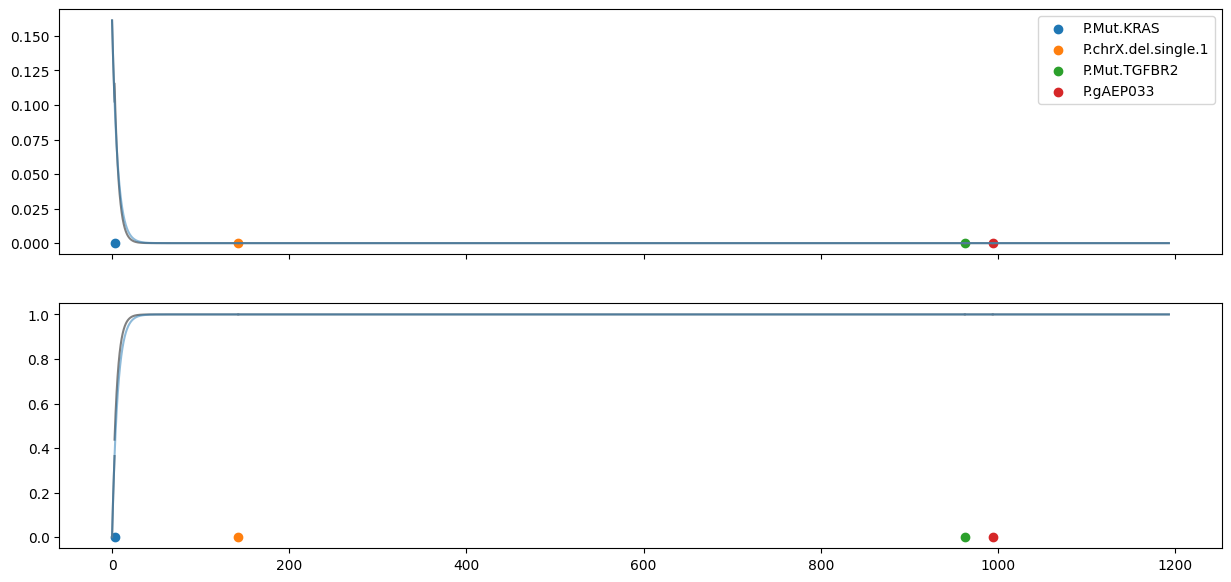

In [75]:
f, a = plt.subplots(2, figsize=(15, 7), sharex=True)
x = np.linspace(0, 5, 100)
rates = np.exp(np.tril(log_theta[np.ix_(order, order)]).sum(axis=1))
times = [(1 / rates[: i + 1]).sum() for i in range(len(order))]
times.append(0)
seeding = log_theta[-1, np.concatenate([np.array([-1]), order])]
for i, event in enumerate(order):
    a[0].scatter(times[i], 0, label=events[event])
    a[1].scatter(times[i], 0, label=events[event])
for i in range(len(order)):
    x = np.arange(0, 1/rates[i], 0.0001) + times[i-1]
    lam = np.exp(seeding[:i+1].sum())
    a[0].plot(x, lam * np.exp(-lam * x), color="grey")

    x = np.arange(times[i-1], times[i], 0.0001)
    a[1].plot(x, 1 - np.exp(-lam * x), color="grey")

x = np.arange(times[-2], 1.2 * times[-2], 0.0001)
lam = np.exp(seeding[:-1].sum())
a[0].plot(x, lam * np.exp(-lam * (x)), color="grey")

x = np.arange(times[-2], 1.2 * times[-2], 0.0001)
a[1].plot(x, 1 - np.exp(-lam * x), color="grey")
a[0].legend()
x = np.arange(0, 1.2 * times[-2], 0.0001)
lam = np.exp(seeding[0])
a[0].plot(x, lam * np.exp(-lam*x), alpha=0.5)
a[1].plot(x, 1 - np.exp(-lam*x), alpha=0.5)


### Seeding Rate Over Time

In [28]:
# Sample times at which to "stop" the simulations 
t1 = np.random.exponential(1/tau1, size=(simulated.shape[0], 1))
pt_courses = np.where(simulated[:, ::2] < t1, simulated[:, ::2], np.inf)

In [31]:
np.where(pt_courses < np.inf, pt_courses.argsort().argsort(), np.inf)

array([[inf, inf, inf, ..., inf, inf,  2.],
       [inf, inf, inf, ..., inf, inf, inf],
       [ 1.,  2., inf, ..., inf, inf,  4.],
       ...,
       [inf, inf, inf, ..., inf, inf, inf],
       [ 0., inf, inf, ..., inf, inf,  1.],
       [inf, inf, inf, ..., inf, inf, inf]])

In [35]:
courses = list()
for i in range(simulated.shape[0]):
    courses.append(pt_courses[i].argsort()[:(pt_courses[i] != np.inf).sum()])

In [48]:
rates = list()
for c in courses:
    rates.append([np.exp(log_theta[-1, c[:i]].sum() + log_theta[-1, -1]) for i in range(len(c) + 1)])